In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%matplotlib inline

In [2]:
%store -r customer_indicators

# Clustering

### Pre-processing

In [24]:
rfm_log = customer_indicators[['RMonetary']].apply(np.log10, axis=1).round(3)
rfm_log['Delta'] = customer_indicators[['Delta']].apply(np.log10, axis=1).round(3)
rfm_log['Recency'] = customer_indicators[['Recency']]#.apply(np.log10, axis=1).round(3)

rfm_k = rfm_log[['Delta', 'Recency', 'RMonetary']]
scaler = StandardScaler()
scaled = scaler.fit_transform(rfm_k.values)

## kmeans

In [4]:
sse = []
silhouette = []
kmax = 9
for k in range(2, kmax):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(scaled)
    sse.append(kmeans.inertia_)
    silhouette.append(silhouette_score(scaled, kmeans.labels_))

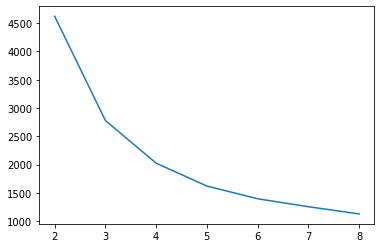

In [5]:
# Elbow curve.
ax = plt.plot(range(2, kmax), sse)
plt.show()

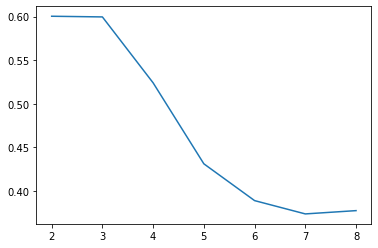

In [6]:
# Silhouette score.
ax = plt.plot(range(2, kmax), silhouette)
plt.show()

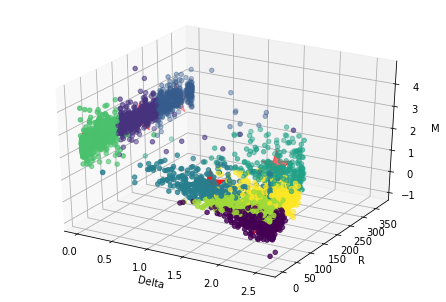

In [7]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_x = centers[:,0]
centroids_y = centers[:,1]
centroids_z = centers[:,2]

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=kmeans.labels_)
ax.scatter(centroids_x,centroids_y,centroids_z,s=1000, marker='*', c='r')
ax.set_xlabel('Delta')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

### Post-processing

In [8]:
centers

array([[2.38084556e+00, 2.98610039e+01, 4.54437580e-01],
       [2.01432161e-02, 1.88412060e+02, 2.39399246e+00],
       [1.72060185e-02, 3.11747685e+02, 2.35332639e+00],
       [1.66187926e+00, 2.98390093e+01, 1.56108669e+00],
       [1.80077350e+00, 2.27055556e+02, 9.79521368e-01],
       [4.12185430e-03, 5.05139073e+01, 2.45331921e+00],
       [2.35528900e+00, 2.11710000e+01, 1.07169200e+00],
       [2.18329710e+00, 1.12828502e+02, 7.37246377e-01]])

In [9]:
# create column containing cluster label
rfm_log['Behavoir'] = kmeans.labels_
rfm_log.head()

,RMonetary,Delta,Recency,Behavoir
0,1.071,2.563,2,6
1,0.706,2.452,75,7
2,3.164,0.000,19,5
3,2.469,0.000,310,2
4,0.725,2.417,36,0


In [10]:
clusters = list()
for i in range(0,7):
    clusters.append(rfm_log[rfm_log['Behavoir'] == i])

In [11]:
for i in range(0,len(clusters)):
    print(clusters[i].describe())

        RMonetary       Delta     Recency  Behavoir
count  777.000000  777.000000  777.000000     777.0
mean     0.454438    2.380846   29.861004       0.0
std      0.236244    0.171065   21.116118       0.0
min     -0.954000    1.322000    1.000000       0.0
25%      0.327000    2.303000   12.000000       0.0
50%      0.500000    2.427000   25.000000       0.0
75%      0.630000    2.507000   45.000000       0.0
max      0.779000    2.571000   94.000000       0.0
        RMonetary       Delta     Recency  Behavoir
count  398.000000  398.000000  398.000000     398.0
mean     2.393992    0.020143  188.412060       1.0
std      0.373519    0.155042   38.585194       0.0
min      1.176000    0.000000  119.000000       1.0
25%      2.146000    0.000000  156.000000       1.0
50%      2.392000    0.000000  189.000000       1.0
75%      2.584750    0.000000  219.750000       1.0
max      4.601000    1.991000  250.000000       1.0
        RMonetary       Delta     Recency  Behavoir
count  432.0

## DBSCAN

In [12]:
# Random parameters selection
density = DBSCAN(eps=0.2, min_samples=5).fit(scaled)
labels = density.labels_
labels

array([0, 0, 1, ..., 0, 0, 0])

In [13]:
dbscan_df = rfm_log.copy()
del dbscan_df['Behavoir']
dbscan_df["label"] = labels

/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/alessio/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


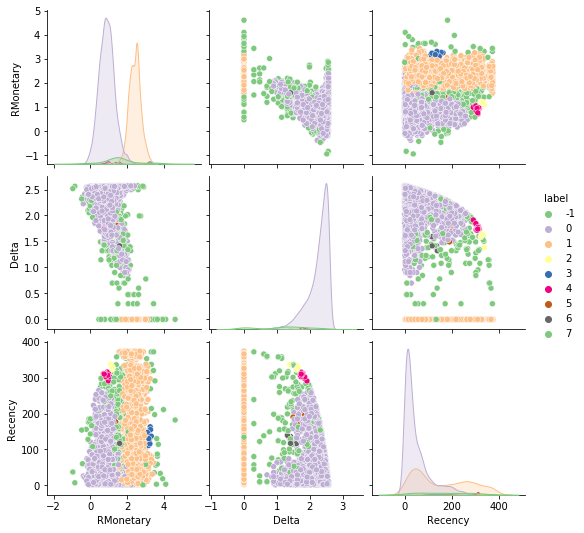

In [14]:
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

## Grid search

In [15]:
eps_to_test = [round(eps,1) for eps in np.arange(0.1, 2, 0.1)]
min_samples_to_test = range(5, 50, 5)

In [16]:
def get_metrics(eps, min_samples, dataset, iter_):
    
    # Fitting ======================================================================
    
    dbscan_model_ = DBSCAN( eps = eps, min_samples = min_samples)
    dbscan_model_.fit(dataset)
    
    # Mean Noise Point Distance metric =============================================
    noise_indices = dbscan_model_.labels_ == -1
    
    if True in noise_indices:
        neighboors = NearestNeighbors(n_neighbors = 6).fit(dataset)
        distances, indices = neighboors.kneighbors(dataset)
        noise_distances = distances[noise_indices, 1:]
        noise_mean_distance = round(noise_distances.mean(), 3)
    else:
        noise_mean_distance = None
        
    # Number of found Clusters metric ==============================================
    
    number_of_clusters = len(set(dbscan_model_.labels_[dbscan_model_.labels_ >= 0]))
    
    # Log ==========================================================================
    
    print("%3d | Tested with eps = %3s and min_samples = %3s | %5s %4s" % (iter_, eps, min_samples, str(noise_mean_distance), number_of_clusters))
        
    return(noise_mean_distance, number_of_clusters)

In [17]:


# Dataframe per la metrica sulla distanza media dei noise points dai K punti più vicini
results_noise = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

# Dataframe per la metrica sul numero di cluster
results_clusters = pd.DataFrame( 
    data = np.zeros((len(eps_to_test),len(min_samples_to_test))), # Empty dataframe
    columns = min_samples_to_test, 
    index = eps_to_test
)

In [18]:
iter_ = 0

print("ITER| INFO%s |  DIST    CLUS" % (" "*39))
print("-"*65)

for eps in eps_to_test:
    for min_samples in min_samples_to_test:
        
        iter_ += 1
        
        # Calcolo le metriche
        noise_metric, cluster_metric = get_metrics(eps, min_samples, scaled, iter_)
        
        # Inserisco i risultati nei relativi dataframe
        results_noise.loc[eps, min_samples] = noise_metric
        results_clusters.loc[eps, min_samples] = cluster_metric



ITER| INFO                                        |  DIST    CLUS
-----------------------------------------------------------------
  1 | Tested with eps = 0.1 and min_samples =   5 | 0.175   24
  2 | Tested with eps = 0.1 and min_samples =  10 | 0.138   20
  3 | Tested with eps = 0.1 and min_samples =  15 | 0.117   11
  4 | Tested with eps = 0.1 and min_samples =  20 | 0.106    6
  5 | Tested with eps = 0.1 and min_samples =  25 | 0.099    2
  6 | Tested with eps = 0.1 and min_samples =  30 | 0.096    4
  7 | Tested with eps = 0.1 and min_samples =  35 | 0.092    4
  8 | Tested with eps = 0.1 and min_samples =  40 | 0.088    1
  9 | Tested with eps = 0.1 and min_samples =  45 | 0.087    1
 10 | Tested with eps = 0.2 and min_samples =   5 | 0.325    8
 11 | Tested with eps = 0.2 and min_samples =  10 | 0.255    4
 12 | Tested with eps = 0.2 and min_samples =  15 | 0.218    3
 13 | Tested with eps = 0.2 and min_samples =  20 | 0.192    2
 14 | Tested with eps = 0.2 and min_samples =  25

129 | Tested with eps = 1.5 and min_samples =  15 |  None    1
130 | Tested with eps = 1.5 and min_samples =  20 |  None    1
131 | Tested with eps = 1.5 and min_samples =  25 |  None    1
132 | Tested with eps = 1.5 and min_samples =  30 |  None    1
133 | Tested with eps = 1.5 and min_samples =  35 |  None    1
134 | Tested with eps = 1.5 and min_samples =  40 |  None    1
135 | Tested with eps = 1.5 and min_samples =  45 |  None    1
136 | Tested with eps = 1.6 and min_samples =   5 |  None    1
137 | Tested with eps = 1.6 and min_samples =  10 |  None    1
138 | Tested with eps = 1.6 and min_samples =  15 |  None    1
139 | Tested with eps = 1.6 and min_samples =  20 |  None    1
140 | Tested with eps = 1.6 and min_samples =  25 |  None    1
141 | Tested with eps = 1.6 and min_samples =  30 |  None    1
142 | Tested with eps = 1.6 and min_samples =  35 |  None    1
143 | Tested with eps = 1.6 and min_samples =  40 |  None    1
144 | Tested with eps = 1.6 and min_samples =  45 |  No

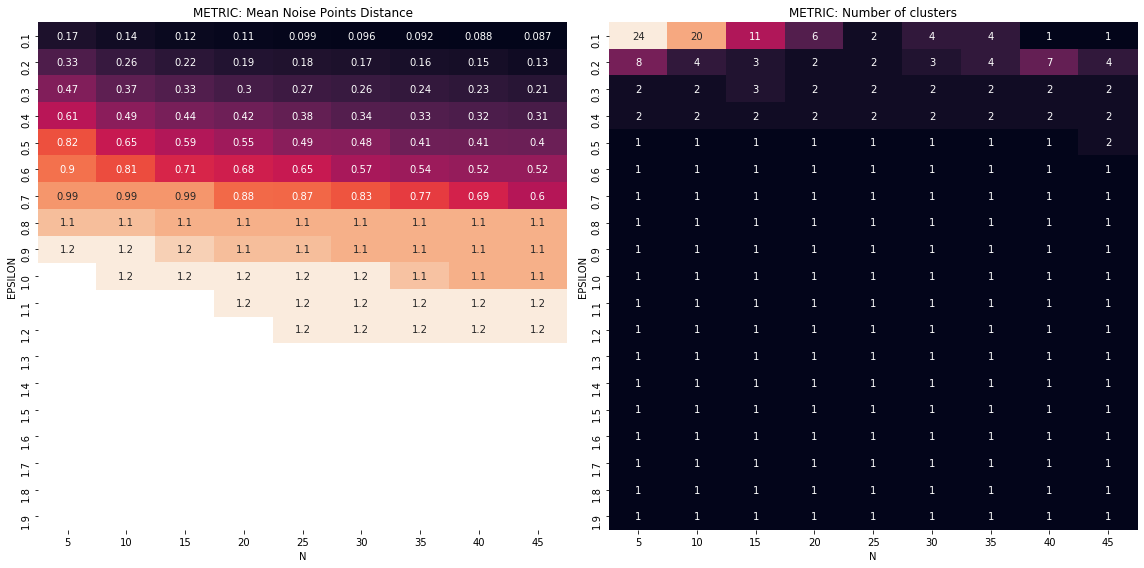

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8) )

sns.heatmap(results_noise, annot = True, ax = ax1, cbar = False).set_title("METRIC: Mean Noise Points Distance")
sns.heatmap(results_clusters, annot = True, ax = ax2, cbar = False).set_title("METRIC: Number of clusters")

ax1.set_xlabel("N"); ax2.set_xlabel("N")
ax1.set_ylabel("EPSILON"); ax2.set_ylabel("EPSILON")

plt.tight_layout(); plt.show()

In [20]:
# Best parameters
density = DBSCAN(eps=0.4, min_samples=5).fit(scaled)
labels = density.labels_

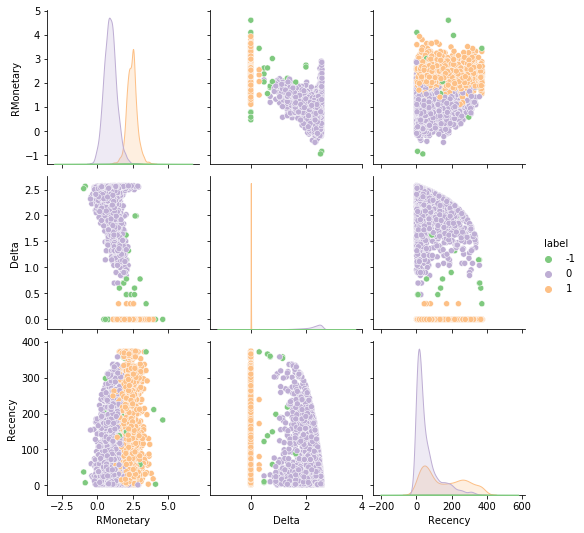

In [21]:
dbscan_df["label"] = labels
sns.pairplot(data = dbscan_df, hue = "label", palette = "Accent")
plt.show()

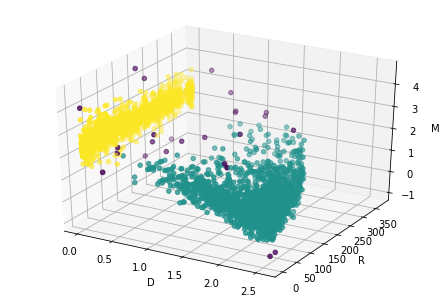

In [22]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(rfm_log['Delta'], rfm_log['Recency'], rfm_log['RMonetary'], c=density.labels_)
ax.set_xlabel('D')
ax.set_ylabel('R')
ax.set_zlabel('M')
plt.show()

# Hierarchical

In [25]:
data_scaled = pd.DataFrame(scaled, columns=rfm_log.columns)

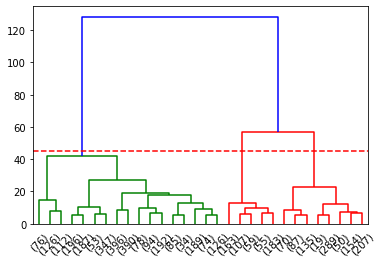

In [26]:
data_dist = pdist(scaled, metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=45, color='r', linestyle='--')

In [27]:
cluster = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled)

array([0, 0, 1, ..., 0, 0, 0])

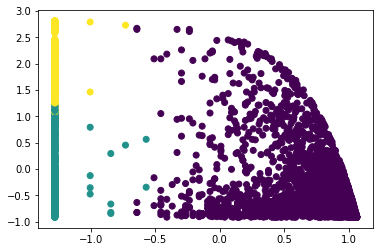

In [28]:
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=cluster.labels_) 

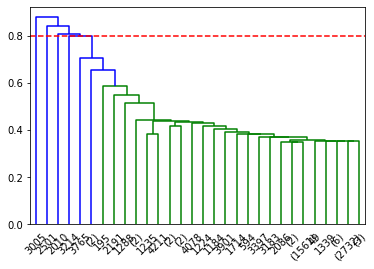

In [29]:
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=0.8, color='r', linestyle='--')

In [30]:
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled)

array([0, 0, 1, ..., 0, 0, 0])

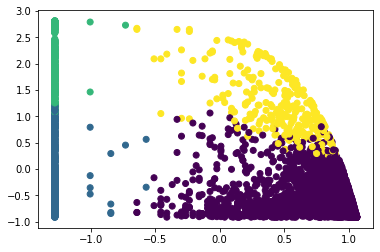

In [31]:
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=cluster.labels_) 

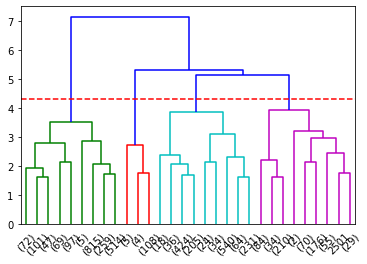

In [32]:
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=4.3, color='r', linestyle='--')

In [33]:
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled)

array([1, 4, 0, ..., 4, 1, 1])

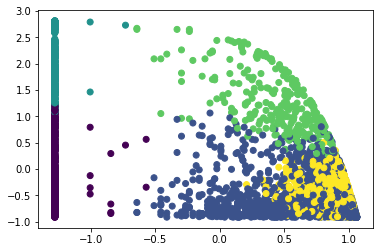

In [34]:
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=cluster.labels_) 

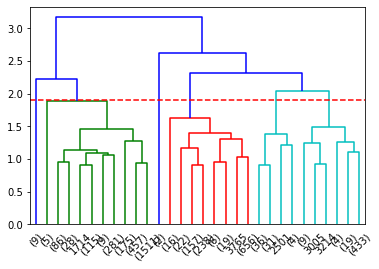

In [35]:
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')
plt.axhline(y=1.9, color='r', linestyle='--')

In [36]:
cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='ward')  
cluster.fit_predict(scaled)

array([6, 4, 3, ..., 4, 6, 0])

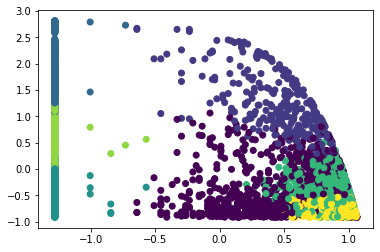

In [37]:
plt.scatter(data_scaled['RMonetary'], data_scaled['Delta'], c=cluster.labels_) 